**Library Imports**

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


**Data Loading**

In [139]:
df_level_start = pd.read_csv('data/level_start.csv')
df_level_end = pd.read_csv('data/level_end.csv')
df_booster_use = pd.read_csv('data/booster_use.csv')
df_playon_use = pd.read_csv('data/playon_use.csv')

**Data Exploration and Overview**

In [141]:
pd.set_option('display.width', 1000)  # expand display
pd.set_option('display.max_columns', None)  # show all columns

# For df_level_start
print("##################### df_level_start ############")
print("##################### Shape #####################")
print(df_level_start.shape)
print("##################### Types #####################")
print(df_level_start.dtypes)
print("##################### Head #####################")
print(df_level_start.head())
print("##################### Tail #####################")
print(df_level_start.tail())
print("##################### NA #####################")
print(df_level_start.isnull().sum())

# For df_level_end
print("##################### df_level_end ############")
print("##################### Shape #####################")
print(df_level_end.shape)
print("##################### Types #####################")
print(df_level_end.dtypes)
print("##################### Head #####################")
print(df_level_end.head())
print("##################### Tail #####################")
print(df_level_end.tail())
print("##################### NA #####################")
print(df_level_end.isnull().sum())

# For df_booster_use
print("##################### df_booster_use ############")
print("##################### Shape #####################")
print(df_booster_use.shape)
print("##################### Types #####################")
print(df_booster_use.dtypes)
print("##################### Head #####################")
print(df_booster_use.head())
print("##################### Tail #####################")
print(df_booster_use.tail())
print("##################### NA #####################")
print(df_booster_use.isnull().sum())

# For df_playon_use
print("##################### df_playon_use ############")
print("##################### Shape #####################")
print(df_playon_use.shape)
print("##################### Types #####################")
print(df_playon_use.dtypes)
print("##################### Head #####################")
print(df_playon_use.head())
print("##################### Tail #####################")
print(df_playon_use.tail())
print("##################### NA #####################")
print(df_playon_use.isnull().sum())

##################### df_level_start ############
##################### Shape #####################
(5258840, 5)
##################### Types #####################
user_id             int64
event_timestamp     int64
level_id           object
unique_id          object
level               int64
dtype: object
##################### Head #####################
   user_id   event_timestamp level_id                             unique_id  level
0      837  1690966083409612   id_184  a2ff5b49-a860-4c39-963f-c1fba6589da6    184
1      837  1690966434340051   id_188  9d6c3826-b812-4b64-99b6-7fe8ba675773    188
2      837  1691000559562241   id_200  ef9da153-cd44-47cc-b784-a3700b4cbe0b    200
3      837  1690966019449602   id_183  e8f57160-32af-4cdb-94c6-0236e7bb0174    183
4      837  1690966244027661   id_186  ed954fbb-365b-4dcf-827a-b5c01a61848b    186
##################### Tail #####################
         user_id   event_timestamp level_id                             unique_id  level
5258835 

In [142]:
# Time adjustment for accuracy and error prevention in record review
df_level_start['event_timestamp'] = pd.to_datetime(df_level_start['event_timestamp'], unit='us')
df_level_end['event_timestamp'] = pd.to_datetime(df_level_end['event_timestamp'], unit='us')
df_booster_use['event_timestamp'] = pd.to_datetime(df_booster_use['event_timestamp'], unit='us')
df_playon_use['event_timestamp'] = pd.to_datetime(df_playon_use['event_timestamp'], unit='us')

In [143]:
# Print the count of unique users for levels 100 and below, and for levels above 100
print(df_level_start[df_level_start["level"] <= 100].user_id.nunique())
print(df_level_start[df_level_start["level"] > 100].user_id.nunique())

13056
15237


In [7]:
print(f"min level for level_start: {min(df_level_start['level'])}")
print(f"max level for level_start: {max(df_level_start['level'])}")
print(f"min level for level_end: {min(df_level_end['level'])}")
print(f"max level for level_end: {max(df_level_end['level'])}")


min level for level_start: 11
max level for level_start: 499
min level for level_end: 11
max level for level_end: 499


Finding the relationship between playon_use, level_start, and level_end and incorporating playon_use as a metric.

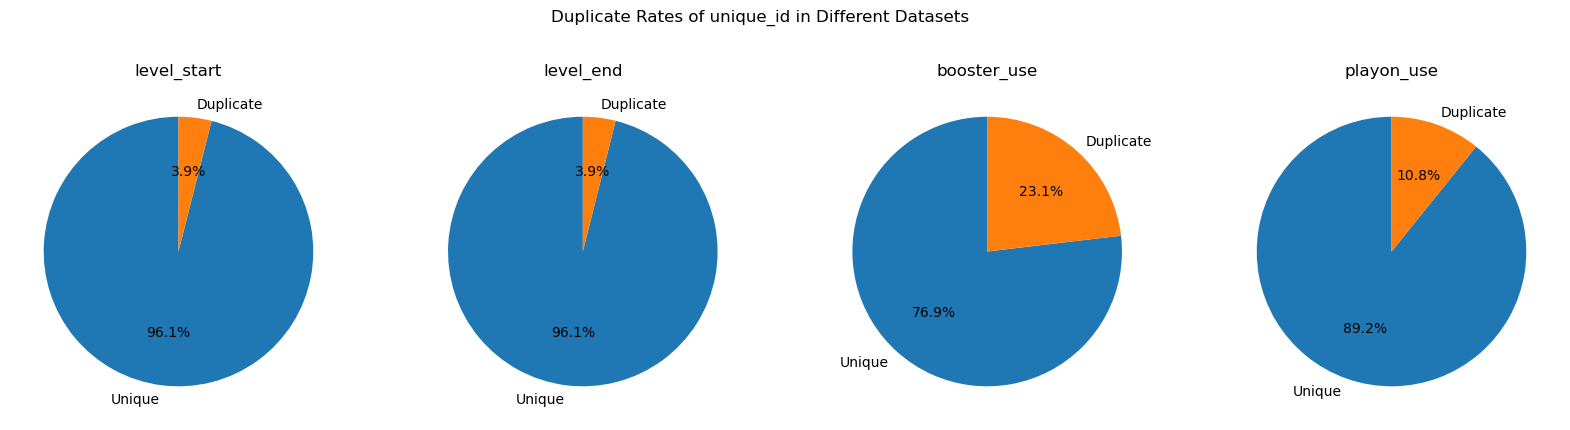

In [9]:
duplicate_rates = {
    'level_start': df_level_start['unique_id'].duplicated().mean(),
    'level_end': df_level_end['unique_id'].duplicated().mean(),
    'booster_use': df_booster_use['unique_id'].duplicated().mean(),
    'playon_use': df_playon_use['unique_id'].duplicated().mean()
}

# Create pie charts
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Duplicate Rates of unique_id in Different Datasets")

for ax, (dataset, rate) in zip(axes, duplicate_rates.items()):
    labels = ['Unique', 'Duplicate']
    sizes = [1 - rate, rate]  # unique and duplicate rates
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(f"{dataset}")

plt.show()

In [10]:
#I don't think there is incorrect logging here; booster uses may have occurred consecutively.
print("Repeated unique_ids in df_booster_use:")
print(df_booster_use[df_booster_use.duplicated(subset=['unique_id'], keep=False)]
      .sort_values(by='unique_id').head())

Repeated unique_ids in df_booster_use:
        user_id            event_timestamp                             unique_id  level
274856    11981 2023-07-28 20:12:26.683591  000363ac-9c16-4adf-a732-05d5d58fc20c    384
274858    11981 2023-07-28 20:12:42.358592  000363ac-9c16-4adf-a732-05d5d58fc20c    384
243589    43509 2023-08-11 18:46:41.518469  00039105-c7f8-4ea8-8a75-a2ad728c07ef    215
243587    43509 2023-08-11 18:47:20.297470  00039105-c7f8-4ea8-8a75-a2ad728c07ef    215
243585    43509 2023-08-11 18:47:55.667471  00039105-c7f8-4ea8-8a75-a2ad728c07ef    215


In [12]:
#I don't think there is incorrect logging here either; playon uses may have occurred consecutively.
print("Repeated unique_ids in:")
print(df_playon_use[df_playon_use.duplicated(subset=['unique_id'], keep=False)]
      .sort_values(by='unique_id').head())

Repeated unique_ids in:
        user_id            event_timestamp                             unique_id  level
111451    87358 2023-08-21 16:15:49.903038  0003dd96-7276-4c87-b53c-0172e81c9720    247
96121     87358 2023-08-21 16:16:26.541044  0003dd96-7276-4c87-b53c-0172e81c9720    247
108706    74580 2023-08-16 11:28:53.802983  000614d8-42df-42e7-87c4-4ab3819d5779    380
200244    74580 2023-08-16 11:29:25.960989  000614d8-42df-42e7-87c4-4ab3819d5779    380
103174    55727 2023-08-11 06:40:35.372067  00091c8e-e2b3-4479-9e8b-149992ca12c4    211


In [13]:
#However, I believe this is a logging error for level_start and level_end
#and I am viewing the randomly repeating entries for level_start
print("Repeated unique_ids in level_start:")
print(df_level_start[df_level_start.duplicated(subset=['unique_id'], keep=False)]
      .sort_values(by='unique_id').head(10))

Repeated unique_ids in level_start:
         user_id            event_timestamp level_id                             unique_id  level
4856350    59092 2023-08-11 22:01:23.261746   id_425  00006d0e-b6b0-4895-a2de-6412134ee51c    425
4856375    59092 2023-08-11 22:03:06.325753   id_425  00006d0e-b6b0-4895-a2de-6412134ee51c    425
3452574    42754 2023-08-19 03:29:03.861172   id_467  0001dc1f-0142-43a9-8ca3-665a4b92bb51    467
3452613    42754 2023-08-19 03:26:47.945166   id_467  0001dc1f-0142-43a9-8ca3-665a4b92bb51    467
5196095    69465 2023-08-11 19:22:41.135279    id_48  0001ece3-2f63-47ee-be2c-f8907b607a9d     48
5196162    69465 2023-08-11 19:23:12.711285    id_48  0001ece3-2f63-47ee-be2c-f8907b607a9d     48
5104535    27278 2023-08-18 01:58:56.086850   id_198  00026730-3e5c-4719-86ce-d4210c287a7d    198
5104464    27278 2023-08-18 01:57:49.428252   id_198  00026730-3e5c-4719-86ce-d4210c287a7d    198
2895714    87358 2023-08-21 16:15:50.722039   id_247  0003dd96-7276-4c87-b53c-0172

In [14]:
#I am testing with a random user and believe it should be unique by looking at 45 and 48.
#In other words, I think cases where unique_id is not unique in the level dataframes indicate an error or duplication.

df_level_start[(df_level_start['user_id'] == 69465) &
                                  (df_level_start['level'] < 50) &
                                  (df_level_start['level'] > 40)].sort_values(by='level')

,user_id,event_timestamp,level_id,unique_id,level
5196029,69465,2023-08-10 19:02:18.207368,id_41,d8a47ff8-8bb3-4e04-99be-1169df35e11c,41
5196068,69465,2023-08-10 19:03:40.162859,id_42,869c47d8-64ba-4798-9a0f-634b22500f0e,42
5196137,69465,2023-08-10 19:04:35.209868,id_43,463084c2-1cda-402e-a1bf-434379dffed1,43
5196089,69465,2023-08-10 19:05:26.529873,id_44,2aaa8085-cb69-4b5c-94a0-94deb0a050c6,44
5196090,69465,2023-08-10 22:59:29.788930,id_45,4a46dadb-21e5-46e3-8b49-900b03f4e53f,45
5196093,69465,2023-08-11 19:18:41.437375,id_45,66fffea7-161d-4047-8b59-55d95d3276f6,45
5196138,69465,2023-08-10 19:22:26.080139,id_45,46bfc5b5-f91e-4bed-9aee-718b2ae5bbcc,45
5196139,69465,2023-08-10 19:06:18.857885,id_45,8e37ca95-eb35-488f-b062-dae5e301f9ba,45
5196094,69465,2023-08-11 19:19:43.599267,id_46,1f78aaff-8f95-4494-a37c-4d9b5af5c40f,46
5196051,69465,2023-08-11 19:20:53.175273,id_47,b1827bf7-f626-475a-a6ea-14ea2b73dd04,47


In [15]:
#I am viewing the randomly repeating entries for level_end, and the player with user_id 69465 has appeared again.
#I don't think this is a coincidence and it may no longer be an error.

print("Repeated unique_ids in level_end:")
print(df_level_end[df_level_end.duplicated(subset=['unique_id'], keep=False)]
      .sort_values(by='unique_id').head(10))

Repeated unique_ids in level_end:
         user_id            event_timestamp level_id                             unique_id  level  remaining_second result
1892671    20204 2023-08-05 12:59:39.889766   id_260  000069d8-15d8-49b3-b969-b7f530d8cd7c    260                 0   fail
2673949    20204 2023-08-05 13:00:17.893703   id_260  000069d8-15d8-49b3-b969-b7f530d8cd7c    260                 6    win
4268638    59092 2023-08-11 22:03:15.162758   id_425  00006d0e-b6b0-4895-a2de-6412134ee51c    425                34    win
3529405    59092 2023-08-11 22:02:58.676749   id_425  00006d0e-b6b0-4895-a2de-6412134ee51c    425                21   fail
4605767    21870 2023-08-04 09:41:20.028525   id_233  000112f9-91db-453c-be92-8583fe4b7f94    233                39    win
2078449    21870 2023-08-04 09:41:16.191516   id_233  000112f9-91db-453c-be92-8583fe4b7f94    233                 0   fail
3654434    42754 2023-08-19 03:29:07.926177   id_467  0001dc1f-0142-43a9-8ca3-665a4b92bb51    467        

In [16]:
#While examining this player's level progress, I see that the remaining time decreases logically.
#I believe this is related to playon usage.

df_level_end[(df_level_end['user_id'] == 69465) &
                                  (df_level_end['level'] < 50) &
                                  (df_level_end['level'] > 40)].sort_values(by='level')

,user_id,event_timestamp,level_id,unique_id,level,remaining_second,result
1477098,69465,2023-08-10 19:03:23.203371,id_41,d8a47ff8-8bb3-4e04-99be-1169df35e11c,41,180,win
5281545,69465,2023-08-10 19:04:22.879862,id_42,869c47d8-64ba-4798-9a0f-634b22500f0e,42,52,win
504311,69465,2023-08-10 19:05:19.206871,id_43,463084c2-1cda-402e-a1bf-434379dffed1,43,110,win
1476173,69465,2023-08-10 19:05:47.459876,id_44,2aaa8085-cb69-4b5c-94a0-94deb0a050c6,44,92,win
341792,69465,2023-08-10 19:23:09.051141,id_45,46bfc5b5-f91e-4bed-9aee-718b2ae5bbcc,45,96,fail
348813,69465,2023-08-10 19:22:17.036136,id_45,8e37ca95-eb35-488f-b062-dae5e301f9ba,45,103,fail
1194270,69465,2023-08-11 19:19:31.253263,id_45,66fffea7-161d-4047-8b59-55d95d3276f6,45,92,win
2104367,69465,2023-08-10 23:02:34.325346,id_45,4a46dadb-21e5-46e3-8b49-900b03f4e53f,45,0,fail
1105714,69465,2023-08-11 19:20:45.090271,id_46,1f78aaff-8f95-4494-a37c-4d9b5af5c40f,46,74,win
1191190,69465,2023-08-11 19:22:33.388277,id_47,b1827bf7-f626-475a-a6ea-14ea2b73dd04,47,95,win


In [17]:
# I am checking the playon use cases.
df_playon_use[(df_playon_use['user_id'] == 69465)].sort_values(by='level')

,user_id,event_timestamp,unique_id,level
141208,69465,2023-08-11 19:23:11.957284,0001ece3-2f63-47ee-be2c-f8907b607a9d,48
214816,69465,2023-08-14 15:08:46.621475,5634f4a8-eacc-4e70-8fad-7af90c0095bf,75
138318,69465,2023-08-14 21:54:58.745714,898ab199-aca5-4f48-9af4-0c4367df73d5,88
221007,69465,2023-08-15 00:53:06.907054,a530bbba-739d-45d0-b356-2e2282c2c883,105
151752,69465,2023-08-15 01:12:27.282137,e8394bf6-1d13-44ca-af6c-c8242873c895,113
18999,69465,2023-08-19 00:05:17.620011,eee976ae-b4fd-4ca9-96fc-72092cff90ec,121
37884,69465,2023-08-20 23:01:46.184448,6731db96-529d-4d9c-921f-a6ba6dbb9a52,151
6234,69465,2023-08-22 20:09:13.536757,417f1f7d-18ea-46f3-bb9c-7c1781d61d03,169
14784,69465,2023-08-22 22:38:38.340579,81f7c4cb-8390-4ca4-abd3-310080e84a27,171


In [18]:
#I understand that level_start is actually unique under normal conditions
#but playon triggers the level_start event again, continuing with the same ID.
#Therefore, there is no duplication.
df_level_start[(df_level_start['user_id'] == 69465) &
                                  (df_level_start['level'] < 77) &
                                  (df_level_start['level'] > 73)].sort_values(by='level')

,user_id,event_timestamp,level_id,unique_id,level
5196034,69465,2023-08-14 15:06:30.491458,id_74,3f7869c1-d066-4e46-8b08-1b9c1afa7645,74
5196004,69465,2023-08-14 15:07:33.822469,id_75,5634f4a8-eacc-4e70-8fad-7af90c0095bf,75
5196123,69465,2023-08-14 15:08:47.372476,id_75,5634f4a8-eacc-4e70-8fad-7af90c0095bf,75
5196005,69465,2023-08-14 21:31:35.968556,id_76,2408ad45-6910-47cd-84a1-0f5a50f49fdc,76


**Some Graphs to Understand Metrics and Game**

Text(0.5, 1.0, 'Distribution of Results in Level End Data')

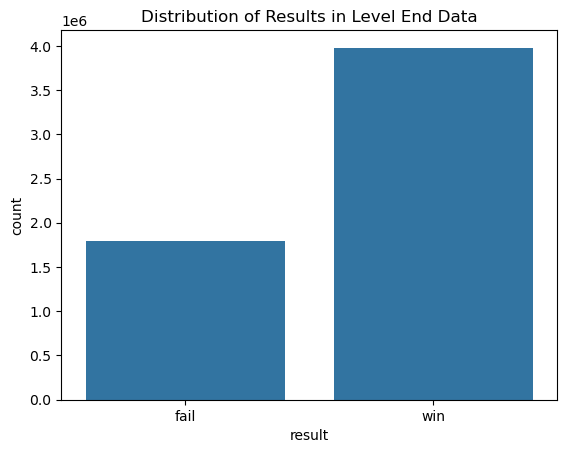

In [20]:
# Plot the distribution of 'result' variable with a count plot
sns.countplot(x="result", data=df_level_end)
plt.title("Distribution of Results in Level End Data")

Text(0.5, 1.0, 'Distribution of Results for Levels 100 and Below')

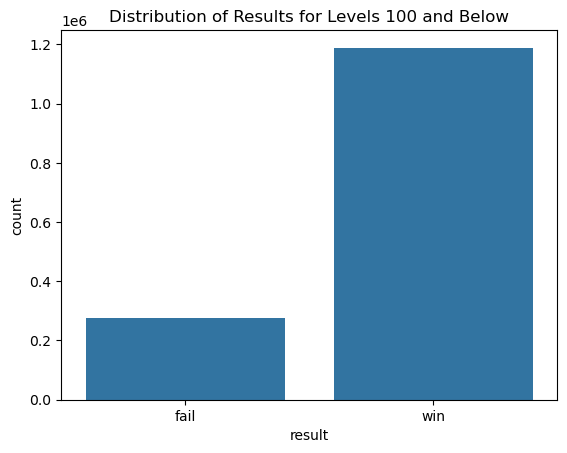

In [21]:
# Plot the distribution of 'result' variable for levels 100 and below
sns.countplot(x="result", data=df_level_end[df_level_end["level"] <= 100])
plt.title("Distribution of Results for Levels 100 and Below")

Text(0.5, 1.0, 'Distribution of Results for Levels Above 100')

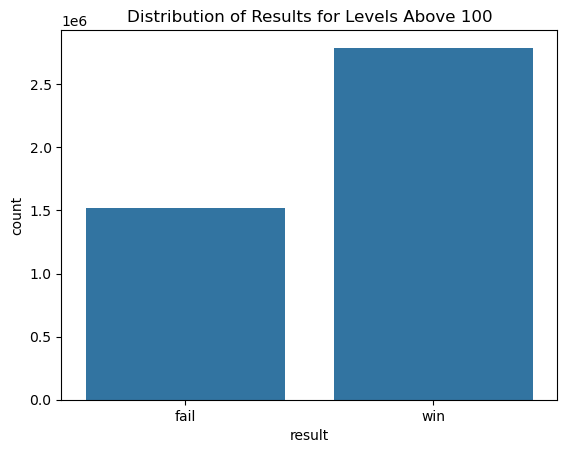

In [22]:
# Plot the distribution of 'result' variable for levels above 100
sns.countplot(x="result", data=df_level_end[df_level_end["level"] > 100])
plt.title("Distribution of Results for Levels Above 100")

Text(0, 0.5, 'Frequency')

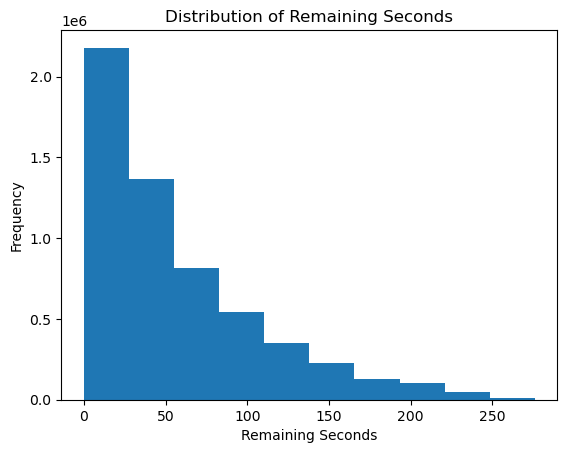

In [23]:
# Plot the distribution of 'remaining_second' variable with a histogram
df_level_end["remaining_second"].plot.hist()
plt.title("Distribution of Remaining Seconds")
plt.xlabel("Remaining Seconds")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

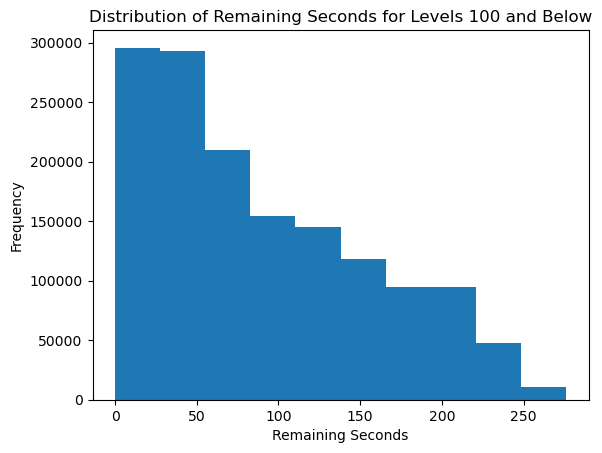

In [24]:
# Plot the distribution of 'remaining_second' variable for levels 100 and below with a histogram
df_level_end[df_level_end["level"] <= 100]["remaining_second"].plot.hist()
plt.title("Distribution of Remaining Seconds for Levels 100 and Below")
plt.xlabel("Remaining Seconds")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

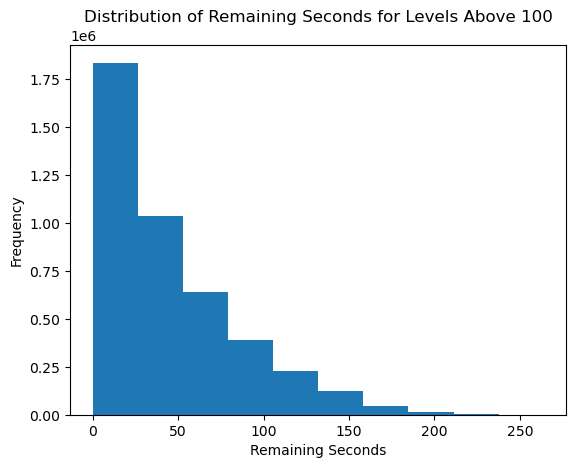

In [25]:
# Plot the distribution of 'remaining_second' variable for levels above 100 with a histogram
df_level_end[df_level_end["level"] > 100]["remaining_second"].plot.hist()
plt.title("Distribution of Remaining Seconds for Levels Above 100")
plt.xlabel("Remaining Seconds")
plt.ylabel("Frequency")


**Data Cleaning and Feature Engineering**

Drop Unnecessary Column(level_id) and Remove Inconsistent Records

In [28]:
# Extract the numeric part from level_id to create a new column
df_level_start['level_id_num'] = df_level_start['level_id'].str.extract('(\d+)').astype(int)
df_level_end['level_id_num'] = df_level_end['level_id'].str.extract('(\d+)').astype(int)

# Save the initial total number of records
initial_total_start = len(df_level_start)
initial_total_end = len(df_level_end)

# Identify and remove inconsistent records based on level_id_num and level comparison
df_level_start = df_level_start[df_level_start['level_id_num'] == df_level_start['level']].copy()
df_level_end = df_level_end[df_level_end['level_id_num'] == df_level_end['level']].copy()

# Drop level_id and level_id_num columns, keeping only the "level" column for level information
df_level_start.drop(columns=['level_id', 'level_id_num'], inplace=True)
df_level_end.drop(columns=['level_id', 'level_id_num'], inplace=True)

# Calculate the final total number of records after removal
final_total_start = len(df_level_start)
final_total_end = len(df_level_end)

# Calculate the number of removed records
removed_start_count = initial_total_start - final_total_start
removed_end_count = initial_total_end - final_total_end

# Print results
print(f"Level Start - Initial Total Records: {initial_total_start}, Removed Records: {removed_start_count}, Remaining Records: {final_total_start}")
print(f"Level End - Initial Total Records: {initial_total_end}, Removed Records: {removed_end_count}, Remaining Records: {final_total_end}")

# Calculate and print the percentage of removed records
start_mismatch_ratio = (removed_start_count / initial_total_start) * 100
end_mismatch_ratio = (removed_end_count / initial_total_end) * 100

print(f"Level Start - Mismatch Ratio: {start_mismatch_ratio:.4f}%")
print(f"Level End - Mismatch Ratio: {end_mismatch_ratio:.4f}%")


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Baran\AppData\Local\Temp\ipykernel_9248\2500445.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_level_start['level_id_num'] = df_level_start['level_id'].str.extract('(\d+)').astype(int)
C:\Users\Baran\AppData\Local\Temp\ipykernel_9248\2500445.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_level_end['level_id_num'] = df_level_end['level_id'].str.extract('(\d+)').astype(int)


Level Start - Initial Total Records: 5258840, Removed Records: 34, Remaining Records: 5258806
Level End - Initial Total Records: 5775617, Removed Records: 243, Remaining Records: 5775374
Level Start - Mismatch Ratio: 0.0006%
Level End - Mismatch Ratio: 0.0042%


Creating not_completed Cloumn

In [30]:
# 1. Create a set of unique unique_id values from df_level_end
end_ids = set(df_level_end['unique_id'].unique())

# 2. Create a copy of the df_level_start dataframe
df_level = df_level_start.copy()

# 3. Add a 'not_completed' column to the df_level dataframe
# If the unique_id exists in level_end, mark as 0; if not, mark as 1
df_level['not_completed'] = df_level['unique_id'].apply(lambda x: 0 if x in end_ids else 1)

# Display rows where not_completed is 0 to check the results
df_level

,user_id,event_timestamp,unique_id,level,not_completed
0,837,2023-08-02 08:48:03.409612,a2ff5b49-a860-4c39-963f-c1fba6589da6,184,0
1,837,2023-08-02 08:53:54.340051,9d6c3826-b812-4b64-99b6-7fe8ba675773,188,0
2,837,2023-08-02 18:22:39.562241,ef9da153-cd44-47cc-b784-a3700b4cbe0b,200,0
3,837,2023-08-02 08:46:59.449602,e8f57160-32af-4cdb-94c6-0236e7bb0174,183,0
4,837,2023-08-02 08:50:44.027661,ed954fbb-365b-4dcf-827a-b5c01a61848b,186,0
...,...,...,...,...,...
5258835,104665,2023-08-21 15:39:46.258988,95847355-74af-4405-8113-1d0b71507ec7,205,0
5258836,104665,2023-08-21 15:48:25.978023,00292fc4-f751-41d1-9377-e3f792d5a7b2,211,0
5258837,104665,2023-08-21 17:37:37.471080,f5336c82-0a1c-444e-a575-c5df9f36ca82,225,0
5258838,104665,2023-08-21 17:47:59.700112,b37e3ca2-c53f-4baa-a59d-3b00a50cc024,230,0


Merging booster use dataset 

In [32]:
# 1. Calculate the booster usage count for each unique_id in the df_booster_use dataframe
booster_use_counts = df_booster_use['unique_id'].value_counts().reset_index()
booster_use_counts.columns = ['unique_id', 'booster_used_count']

# 2. Perform a left join to add the booster_used_count column to the df_level dataframe
df_level = pd.merge(df_level, booster_use_counts, on='unique_id', how='left')

# If booster_used_count remains as NaN (no booster usage), fill it with 0
df_level['booster_used_count'] = df_level['booster_used_count'].fillna(0).astype(int)

# Display the first few rows to check the results
df_level

,user_id,event_timestamp,unique_id,level,not_completed,booster_used_count
0,837,2023-08-02 08:48:03.409612,a2ff5b49-a860-4c39-963f-c1fba6589da6,184,0,0
1,837,2023-08-02 08:53:54.340051,9d6c3826-b812-4b64-99b6-7fe8ba675773,188,0,0
2,837,2023-08-02 18:22:39.562241,ef9da153-cd44-47cc-b784-a3700b4cbe0b,200,0,0
3,837,2023-08-02 08:46:59.449602,e8f57160-32af-4cdb-94c6-0236e7bb0174,183,0,0
4,837,2023-08-02 08:50:44.027661,ed954fbb-365b-4dcf-827a-b5c01a61848b,186,0,0
...,...,...,...,...,...,...
5258801,104665,2023-08-21 15:39:46.258988,95847355-74af-4405-8113-1d0b71507ec7,205,0,0
5258802,104665,2023-08-21 15:48:25.978023,00292fc4-f751-41d1-9377-e3f792d5a7b2,211,0,0
5258803,104665,2023-08-21 17:37:37.471080,f5336c82-0a1c-444e-a575-c5df9f36ca82,225,0,0
5258804,104665,2023-08-21 17:47:59.700112,b37e3ca2-c53f-4baa-a59d-3b00a50cc024,230,0,0


Steps to find the number of playon uses after the above discovery.


In [34]:
# 1. Calculate the number of playon_use events for each unique_id in the playon_use dataframe
playon_use_counts = df_playon_use['unique_id'].value_counts().reset_index()
playon_use_counts.columns = ['unique_id', 'playon_used_count']

# 2. For level_start, get the first records using min(event_timestamp)
level_start_dedup = df_level.sort_values(by='event_timestamp').drop_duplicates(subset='unique_id', keep='first')

# 3. For level_end, get the last records using max(event_timestamp)
level_end_dedup = df_level_end.sort_values(by='event_timestamp', ascending=False).drop_duplicates(subset='unique_id', keep='first')

# 4. Add the playon_used_count column to the level_start dataframe
# Using a left join, merge playon_use_counts with level_start_dedup
level_start_dedup = level_start_dedup.merge(playon_use_counts, on='unique_id', how='left')

# If playon_used_count remains as NaN (no playon_use), fill it with 0
level_start_dedup['playon_used_count'] = level_start_dedup['playon_used_count'].fillna(0).astype(int)

# 5. Combine level_start and level_end dataframes to create the final dataset
merged_level_df = pd.merge(level_start_dedup,
                    level_end_dedup[['unique_id', 'event_timestamp', 'remaining_second', 'result']],
                    how='left',
                    on='unique_id',
                    suffixes=('_start', '_end'))

# Display the first few rows to check the results
merged_level_df

,user_id,event_timestamp_start,unique_id,level,not_completed,booster_used_count,playon_used_count,event_timestamp_end,remaining_second,result
0,24679,2023-07-27 04:35:19.631517,561029df-000f-4167-911b-4a8f0d278833,11,0,0,0,2023-07-27 04:35:47.284519,217.0,win
1,24674,2023-07-27 04:35:37.216219,c74cd72e-73a6-41b9-9108-e409ee217644,11,0,0,0,2023-07-27 04:36:19.155221,203.0,win
2,24679,2023-07-27 04:35:55.030522,28134003-b18a-4c11-93fb-a729602c7b4f,12,0,0,0,2023-07-27 04:36:19.060524,160.0,win
3,24679,2023-07-27 04:36:43.098536,c59cfcc6-65f7-4ea8-8205-aebe65fa02d5,13,0,1,0,2023-07-27 04:37:46.682541,196.0,win
4,24674,2023-07-27 04:36:57.702242,3f922510-6896-4e07-8be7-fdfff9de2129,12,0,0,0,2023-07-27 04:38:22.382409,99.0,fail
...,...,...,...,...,...,...,...,...,...,...
5051206,95500,2023-08-22 23:59:49.281478,525e83ef-2e1f-4a28-a9fd-cf47a7d5d5ca,260,1,0,0,NaT,NaN,NaN
5051207,69449,2023-08-22 23:59:52.321798,05ad0e1b-c422-4de9-b296-4a0e00a0f108,141,1,0,0,NaT,NaN,NaN
5051208,56773,2023-08-22 23:59:52.541212,b21e76fc-657e-4a22-8317-aeb7987d2f70,148,1,0,0,NaT,NaN,NaN
5051209,32020,2023-08-22 23:59:53.585629,252b6785-690a-498a-827a-92bc95a01600,461,1,0,0,NaT,NaN,NaN


**Handling Missing Values and Optimizing Data Types**

In [37]:
#Some of the level_end data is Null 
#because we added a not_completed column to df_level_start 
#for players who exited without completing the level
print(merged_level_df.isnull().sum())

user_id                      0
event_timestamp_start        0
unique_id                    0
level                        0
not_completed                0
booster_used_count           0
playon_used_count            0
event_timestamp_end      32742
remaining_second         32742
result                   32742
dtype: int64


In [39]:
# Fill null values in 'event_timestamp_end' with 0
merged_level_df['event_timestamp_end'].fillna(0, inplace=True)
merged_level_df['result'].fillna(0, inplace=True)

# For 'remaining_second' and 'result', fill null values with each user's mean
merged_level_df['remaining_second'] = merged_level_df.groupby('user_id')['remaining_second'].transform(lambda x: x.fillna(x.mean()))
print(merged_level_df.isnull().sum())

C:\Users\Baran\AppData\Local\Temp\ipykernel_9248\1435534316.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_level_df['event_timestamp_end'].fillna(0, inplace=True)
C:\Users\Baran\AppData\Local\Temp\ipykernel_9248\1435534316.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_level_df['event_timestamp_end'].fillna(0, inplace=True

user_id                  0
event_timestamp_start    0
unique_id                0
level                    0
not_completed            0
booster_used_count       0
playon_used_count        0
event_timestamp_end      0
remaining_second         0
result                   0
dtype: int64


In [42]:
merged_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051211 entries, 0 to 5051210
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   user_id                int64         
 1   event_timestamp_start  datetime64[ns]
 2   unique_id              object        
 3   level                  int64         
 4   not_completed          int64         
 5   booster_used_count     int32         
 6   playon_used_count      int32         
 7   event_timestamp_end    object        
 8   remaining_second       float64       
 9   result                 object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(3)
memory usage: 346.8+ MB


Map the 'result' column to binary values: 1 for 'win' and 0 for 'fail'

In [44]:
merged_level_df['result'] = merged_level_df['result'].map({'win': 1, 'fail': 0})
merged_level_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5051211 entries, 0 to 5051210
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   user_id                int64         
 1   event_timestamp_start  datetime64[ns]
 2   unique_id              object        
 3   level                  int64         
 4   not_completed          int64         
 5   booster_used_count     int32         
 6   playon_used_count      int32         
 7   event_timestamp_end    object        
 8   remaining_second       float64       
 9   result                 float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(3), object(2)
memory usage: 346.8+ MB


In [45]:
# Display summary statistics for selected columns
print(f"unique user count: {merged_level_df['user_id'].nunique()}")
print(f"unique played level count: {merged_level_df['unique_id'].nunique()}")
print(f"unique level count: {merged_level_df['level'].nunique()}")

with pd.option_context('display.float_format', '{:.2f}'.format):
    print(merged_level_df[['level','not_completed', 'booster_used_count', 'playon_used_count', 'remaining_second', 'result']].describe())

unique user count: 15237
unique played level count: 5051211
unique level count: 489
           level  not_completed  booster_used_count  playon_used_count  remaining_second     result
count 5051211.00     5051211.00          5051211.00         5051211.00        5051211.00 5018469.00
mean      200.89           0.01                0.08               0.04             55.74       0.72
std       126.73           0.08                0.37               0.23             52.57       0.45
min        11.00           0.00                0.00               0.00              0.00       0.00
25%        98.00           0.00                0.00               0.00             16.00       0.00
50%       176.00           0.00                0.00               0.00             41.00       1.00
75%       288.00           0.00                0.00               0.00             81.00       1.00
max       499.00           1.00               54.00              15.00            276.00       1.00


**Filtering Records Below Level 100 for the Model**

In [47]:
# Filter to include only levels <= 100 
df_levels_below_100 = merged_level_df[merged_level_df['level'] <= 100]
df_levels_below_100

,user_id,event_timestamp_start,unique_id,level,not_completed,booster_used_count,playon_used_count,event_timestamp_end,remaining_second,result
0,24679,2023-07-27 04:35:19.631517,561029df-000f-4167-911b-4a8f0d278833,11,0,0,0,2023-07-27 04:35:47.284519,217.0,1.0
1,24674,2023-07-27 04:35:37.216219,c74cd72e-73a6-41b9-9108-e409ee217644,11,0,0,0,2023-07-27 04:36:19.155221,203.0,1.0
2,24679,2023-07-27 04:35:55.030522,28134003-b18a-4c11-93fb-a729602c7b4f,12,0,0,0,2023-07-27 04:36:19.060524,160.0,1.0
3,24679,2023-07-27 04:36:43.098536,c59cfcc6-65f7-4ea8-8205-aebe65fa02d5,13,0,1,0,2023-07-27 04:37:46.682541,196.0,1.0
4,24674,2023-07-27 04:36:57.702242,3f922510-6896-4e07-8be7-fdfff9de2129,12,0,0,0,2023-07-27 04:38:22.382409,99.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5049321,101484,2023-08-22 22:20:30.340585,ab799477-df8e-42a9-ab37-bd02814cf0a7,96,0,0,0,2023-08-22 22:20:59.759589,32.0,1.0
5049333,101484,2023-08-22 22:21:14.389591,63a39ed2-bfbd-43f6-b4e6-bfdb0ff57de9,97,0,0,0,2023-08-22 22:22:12.288595,49.0,1.0
5049357,101484,2023-08-22 22:22:23.643597,e7fb2c2f-1a90-4028-9ae2-938641818b03,98,0,0,0,2023-08-22 22:23:18.880601,63.0,1.0
5049375,101484,2023-08-22 22:23:38.575603,7c2e0ae5-8a8a-48c9-a8a8-5a3d54432337,99,0,0,0,2023-08-22 22:24:18.729607,19.0,1.0


Calculating summary statistics 

In [50]:
user_level_stats = df_levels_below_100.groupby(['user_id']).agg(
    win_rate=('result', 'mean'),
    not_completed_count=('not_completed','sum'),
    avg_remaining_second=('remaining_second', 'mean'),
    booster_used_count=('booster_used_count', 'sum'),
    playon_used_count=('playon_used_count', 'sum')
).reset_index()
user_level_stats

,user_id,win_rate,not_completed_count,avg_remaining_second,booster_used_count,playon_used_count
0,11,0.946429,3,61.622793,8,4
1,38,0.689655,0,53.793103,0,0
2,397,0.636364,0,47.818182,1,1
3,466,0.955556,0,90.855556,0,0
4,491,0.943662,0,74.267606,0,2
...,...,...,...,...,...,...
13051,105018,0.762712,0,69.144068,1,0
13052,105038,1.000000,0,101.688889,109,39
13053,105042,0.957447,0,107.095745,5,0
13054,105051,0.947368,0,99.410526,3,1


Data Scaling For Clustering

In [66]:
scaler = StandardScaler()
scaled_features_level = scaler.fit_transform(user_level_stats[['win_rate','not_completed_count','avg_remaining_second', 
                                                               'booster_used_count', 'playon_used_count']])
scaled_features_level[:5]

array([[ 0.66336756,  2.2348731 , -1.39389176,  0.20785869,  0.44605961],
       [-1.16157701, -0.50789706, -1.7989398 , -0.79386807, -0.67859722],
       [-1.54033158, -0.50789706, -2.10803636, -0.66865223, -0.39743302],
       [ 0.72823503, -0.50789706,  0.1183869 , -0.79386807, -0.67859722],
       [ 0.64370474, -0.50789706, -0.73974626, -0.79386807, -0.11626881]])

**CLUSTERING**

Examining the performance of different algorithms to observe the best clustering performance.

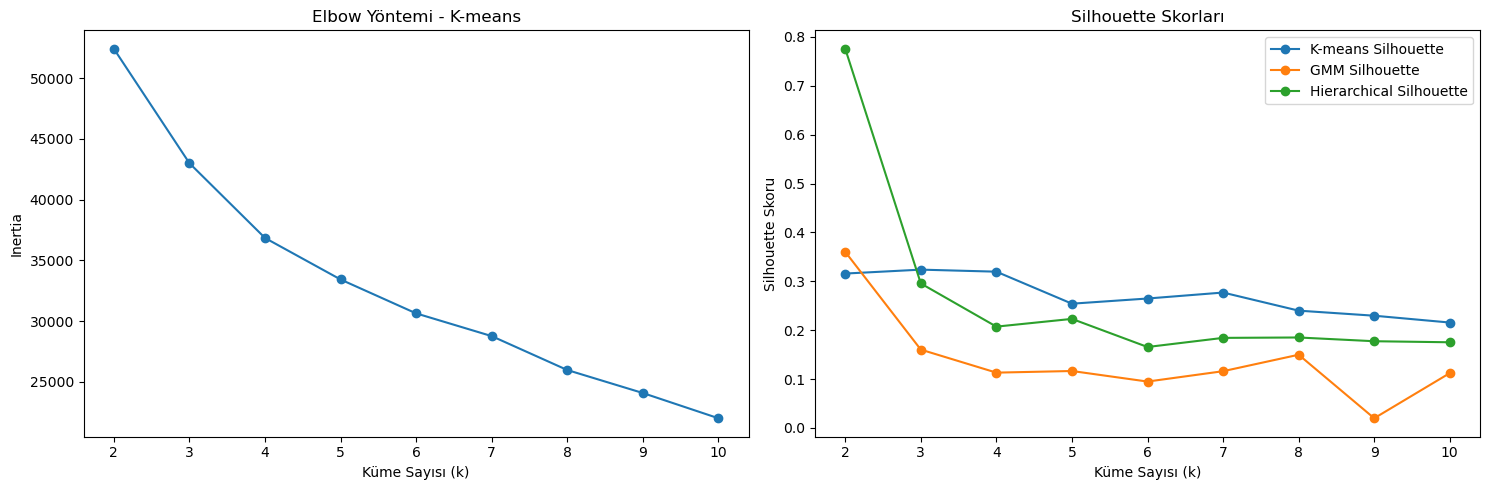

In [81]:

# Küme sayısı aralığı
k_range = range(2, 11)

# K-means için inertia ve silhouette skorları
inertia_values_kmeans = []
silhouette_scores_kmeans = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_level)
    inertia_values_kmeans.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_features_level, kmeans.labels_)
    silhouette_scores_kmeans.append(silhouette_avg)

# GMM için silhouette skorları
silhouette_scores_gmm = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(scaled_features_level)
    silhouette_avg = silhouette_score(scaled_features_level, gmm_labels)
    silhouette_scores_gmm.append(silhouette_avg)

# Hiyerarşik Kümeleme için silhouette skorları
silhouette_scores_hierarchical = []

for k in k_range:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    hierarchical_labels = hierarchical.fit_predict(scaled_features_level)
    silhouette_avg = silhouette_score(scaled_features_level, hierarchical_labels)
    silhouette_scores_hierarchical.append(silhouette_avg)

# Elbow Yöntemi Grafiği (K-means)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values_kmeans, marker='o', label='Inertia')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Yöntemi - K-means")

# Silhouette Skoru Grafiği (K-means, GMM ve Hiyerarşik Kümeleme)
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_kmeans, marker='o', label='K-means Silhouette')
plt.plot(k_range, silhouette_scores_gmm, marker='o', label='GMM Silhouette')
plt.plot(k_range, silhouette_scores_hierarchical, marker='o', label='Hierarchical Silhouette')
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Silhouette Skoru")
plt.title("Silhouette Skorları")
plt.legend()

plt.tight_layout()
plt.show()


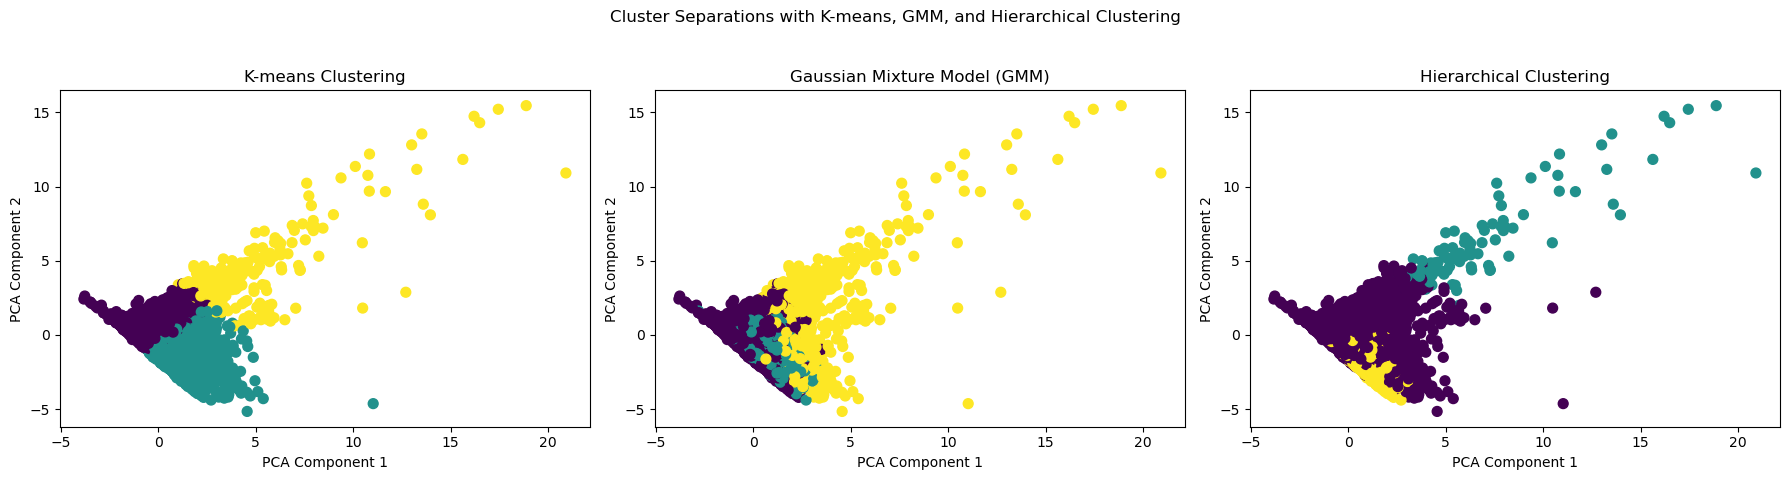

In [82]:
# Dimensionality reduction to two components using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features_level)

# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features_level)

# Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(scaled_features_level)

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(scaled_features_level)

# Visualizing Cluster Separations
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# K-means Visualization
axs[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', s=50)
axs[0].set_title("K-means Clustering")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

# GMM Visualization
axs[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=gmm_labels, cmap='viridis', s=50)
axs[1].set_title("Gaussian Mixture Model (GMM)")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

# Hierarchical Clustering Visualization
axs[2].scatter(reduced_features[:, 0], reduced_features[:, 1], c=hierarchical_labels, cmap='viridis', s=50)
axs[2].set_title("Hierarchical Clustering")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")

plt.suptitle("Cluster Separations with K-means, GMM, and Hierarchical Clustering")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Silhouette Score

In [88]:
silhouette_avg = silhouette_score(scaled_features_level, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3238333495558105


**Analysis of Player Segments**

In [91]:
user_level_stats['Cluster'] = kmeans_labels

cluster_summary = user_level_stats.groupby('Cluster').agg({
    'win_rate': ['mean', 'median'],
    'not_completed_count': ['mean', 'median'],
    'avg_remaining_second': ['mean', 'median'],
    'booster_used_count': ['mean', 'median'],
    'playon_used_count': ['mean', 'median']
})

display(cluster_summary)

win_rate           not_completed_count        avg_remaining_second            booster_used_count        playon_used_count       
             mean    median                mean median                 mean     median               mean median              mean median
Cluster                                                                                                                                  
0        0.918497  0.937500            0.312231    0.0            96.931592  97.273372           5.754473    5.0          2.262967    2.0
1        0.709586  0.729619            1.072782    1.0            70.565821  72.168612           5.917498    5.0          1.739282    1.0
2        0.844755  0.900000            0.897196    0.0            80.916277  80.093114          38.420561   28.0         21.266355   18.0

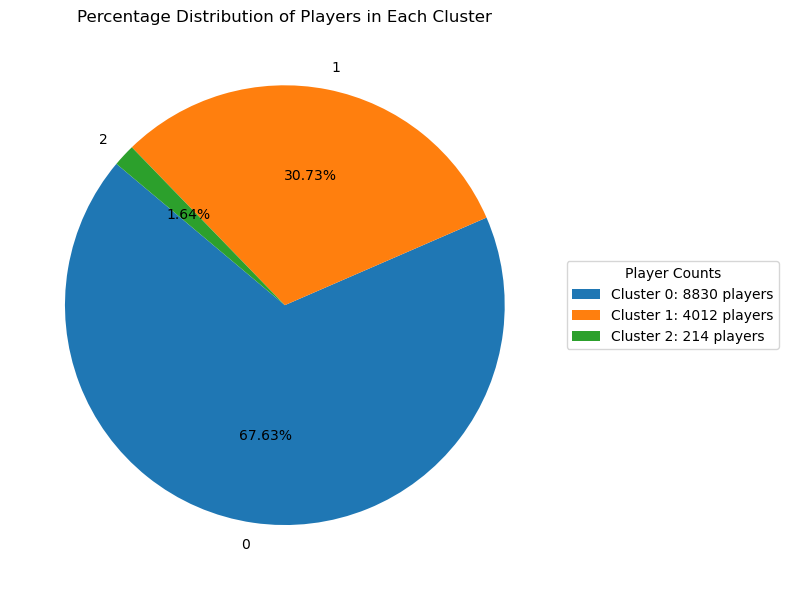

In [93]:
# Calculate the player counts and percentage distribution for each cluster
player_counts = user_level_stats.groupby('Cluster')['user_id'].count()
total_players = player_counts.sum()
player_percentages = (player_counts / total_players) * 100

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(player_percentages, labels=player_counts.index, autopct='%1.2f%%', startangle=140)
plt.title("Percentage Distribution of Players in Each Cluster")

# Adding player counts as text in the upper right corner
player_info = [f'Cluster {index}: {count} players' for index, count in player_counts.items()]
plt.legend(player_info, loc="center left", bbox_to_anchor=(1, 0.5), title="Player Counts")

plt.tight_layout()
plt.show()


Creating graphs to understand the skills of the segments

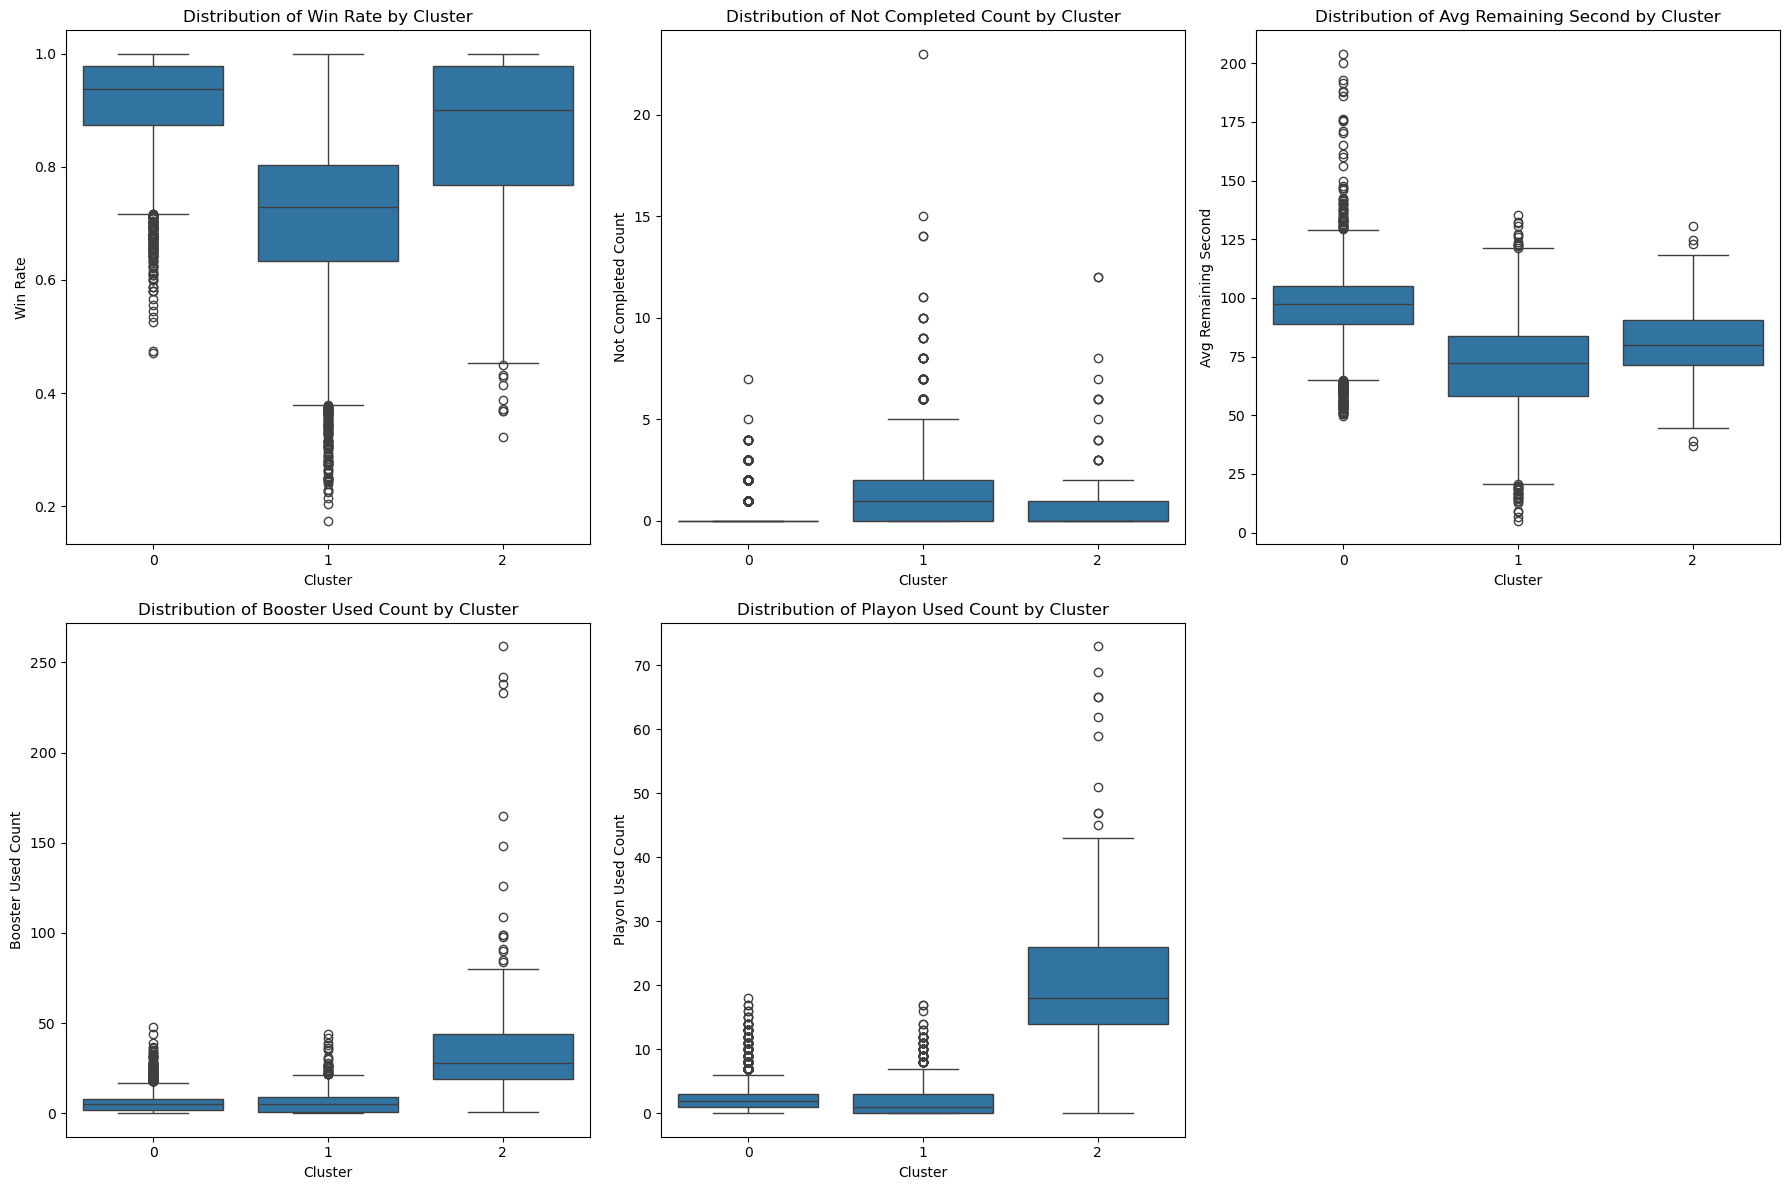

In [107]:
# Visualize the distribution of various metrics across clusters with boxplots
plt.figure(figsize=(18, 12))

metrics = ['win_rate', 'not_completed_count', 'avg_remaining_second', 'booster_used_count', 'playon_used_count']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x='Cluster', y=metric, data=user_level_stats, )
    plt.title(f'Distribution of {metric.replace("_", " ").title()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric.replace("_", " ").title())

plt.tight_layout()
plt.show()

**Examining and Validating the Relationship Between Post-Level 100 Performance and Segments**

In [111]:
# Filter the dataframe to include only levels above 100
level_100_plus_df = merged_level_df[merged_level_df['level'] > 100]
level_100_plus_df

,user_id,event_timestamp_start,unique_id,level,not_completed,booster_used_count,playon_used_count,event_timestamp_end,remaining_second,result
241,17317,2023-07-27 05:45:42.466205,2d40f320-7f5e-49f8-b3c4-821e89a27ae8,110,0,0,0,2023-07-27 05:47:34.947209,88.000000,1.0
273,17317,2023-07-27 05:51:57.634215,5e3baf69-7b3b-4662-80ca-caafed17f4f1,111,0,0,0,2023-07-27 05:53:28.337217,0.000000,0.0
282,17317,2023-07-27 05:53:38.412221,43bef9dd-c9e2-4643-b2e7-7df55594457f,111,0,0,0,2023-07-27 05:55:20.817223,0.000000,0.0
298,17317,2023-07-27 05:56:33.950187,b957453e-7b38-48ea-ab49-b0daa28c1a90,111,0,0,0,2023-07-27 05:57:54.333191,16.000000,1.0
315,17317,2023-07-27 05:58:20.777194,b950d9b2-7717-4ea7-b13b-bd935b2a0187,112,0,0,0,2023-07-27 05:59:52.297198,16.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
5051206,95500,2023-08-22 23:59:49.281478,525e83ef-2e1f-4a28-a9fd-cf47a7d5d5ca,260,1,0,0,0,50.842640,NaN
5051207,69449,2023-08-22 23:59:52.321798,05ad0e1b-c422-4de9-b296-4a0e00a0f108,141,1,0,0,0,95.020725,NaN
5051208,56773,2023-08-22 23:59:52.541212,b21e76fc-657e-4a22-8317-aeb7987d2f70,148,1,0,0,0,83.493506,NaN
5051209,32020,2023-08-22 23:59:53.585629,252b6785-690a-498a-827a-92bc95a01600,461,1,0,0,0,40.282353,NaN


In [113]:
# Summarize metrics for users in levels above 100
level_100_plus_summary = level_100_plus_df.groupby('user_id').agg(
    win_rate=('result', 'mean'),
    not_completed_count=('not_completed', 'sum'), 
    avg_remaining_second=('remaining_second', 'mean'),
    booster_used_count=('booster_used_count', 'sum'),
    playon_used_count=('playon_used_count', 'sum')
).reset_index()

level_100_plus_summary

,user_id,win_rate,not_completed_count,avg_remaining_second,booster_used_count,playon_used_count
0,4,0.544554,13,30.107261,38,5
1,11,0.832740,1,51.899226,58,20
2,38,0.726457,0,53.717489,16,1
3,75,0.388027,3,81.430155,28,0
4,91,0.624642,1,21.891117,20,11
...,...,...,...,...,...,...
15232,105038,1.000000,0,49.806818,51,62
15233,105042,0.833333,0,41.814815,8,3
15234,105051,1.000000,0,50.250000,0,3
15235,105071,0.738318,0,42.990654,8,2


In [115]:
# Print the count of unique users for levels 100 and below, and for levels above 100
print(merged_level_df[merged_level_df["level"] <= 100].user_id.nunique())
print(merged_level_df[merged_level_df["level"] > 100].user_id.nunique())

13056
15237


Merging Segments for Post-Level 100

In [117]:
# Merge user segmentation data with level 100+ summary data
user_segments = user_level_stats[['user_id', 'Cluster']].drop_duplicates()
level_100_plus_summary = pd.merge(level_100_plus_summary, user_segments, on='user_id')

level_100_plus_summary

,user_id,win_rate,not_completed_count,avg_remaining_second,booster_used_count,playon_used_count,Cluster
0,11,0.832740,1,51.899226,58,20,1
1,38,0.726457,0,53.717489,16,1,1
2,397,0.541063,1,31.260343,9,4,1
3,466,0.698592,0,33.450704,0,0,0
4,491,0.780612,0,52.571429,7,9,0
...,...,...,...,...,...,...,...
13051,105018,0.552632,0,25.947368,4,0,1
13052,105038,1.000000,0,49.806818,51,62,2
13053,105042,0.833333,0,41.814815,8,3,0
13054,105051,1.000000,0,50.250000,0,3,0


In [119]:
level_100_plus_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13056 entries, 0 to 13055
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               13056 non-null  int64  
 1   win_rate              13056 non-null  float64
 2   not_completed_count   13056 non-null  int64  
 3   avg_remaining_second  13056 non-null  float64
 4   booster_used_count    13056 non-null  int32  
 5   playon_used_count     13056 non-null  int32  
 6   Cluster               13056 non-null  int32  
dtypes: float64(2), int32(3), int64(2)
memory usage: 561.1 KB


Calculating Average Performance Metrics Post-Level 100 by Segments

In [121]:
print("######################### PRE-LEVEL 100 #########################")
display(cluster_summary)
print("######################### POST-LEVEL 100 ######################## ")
segment_performance_summary = level_100_plus_summary.groupby('Cluster').agg({
    'win_rate': ['mean', 'median'],
    'not_completed_count': ['mean', 'median'],
    'avg_remaining_second': ['mean', 'median'],
    'booster_used_count': ['mean', 'median'],
    'playon_used_count': ['mean', 'median']
}).reset_index()

display(segment_performance_summary)

######################### PRE-LEVEL 100 #########################


win_rate           not_completed_count        avg_remaining_second            booster_used_count        playon_used_count       
             mean    median                mean median                 mean     median               mean median              mean median
Cluster                                                                                                                                  
0        0.918497  0.937500            0.312231    0.0            96.931592  97.273372           5.754473    5.0          2.262967    2.0
1        0.709586  0.729619            1.072782    1.0            70.565821  72.168612           5.917498    5.0          1.739282    1.0
2        0.844755  0.900000            0.897196    0.0            80.916277  80.093114          38.420561   28.0         21.266355   18.0

######################### POST-LEVEL 100 ######################## 


Cluster  win_rate           not_completed_count        avg_remaining_second            booster_used_count        playon_used_count       
               mean    median                mean median                 mean     median               mean median              mean median
0       0  0.794824  0.793103            1.201133    0.0            45.313830  44.152389          21.021744   11.0         11.195696    5.0
1       1  0.572283  0.577978            2.244516    1.0            46.047597  43.831634          17.032652    8.0          7.268694    3.0
2       2  0.748451  0.799467            1.953271    1.0            42.053979  38.340700         117.957944   61.5         79.621495   39.0

**Creating Graphs To Observe The Alignment With Pre-Level 100 Data**

######################### PRE-LEVEL 100 #########################


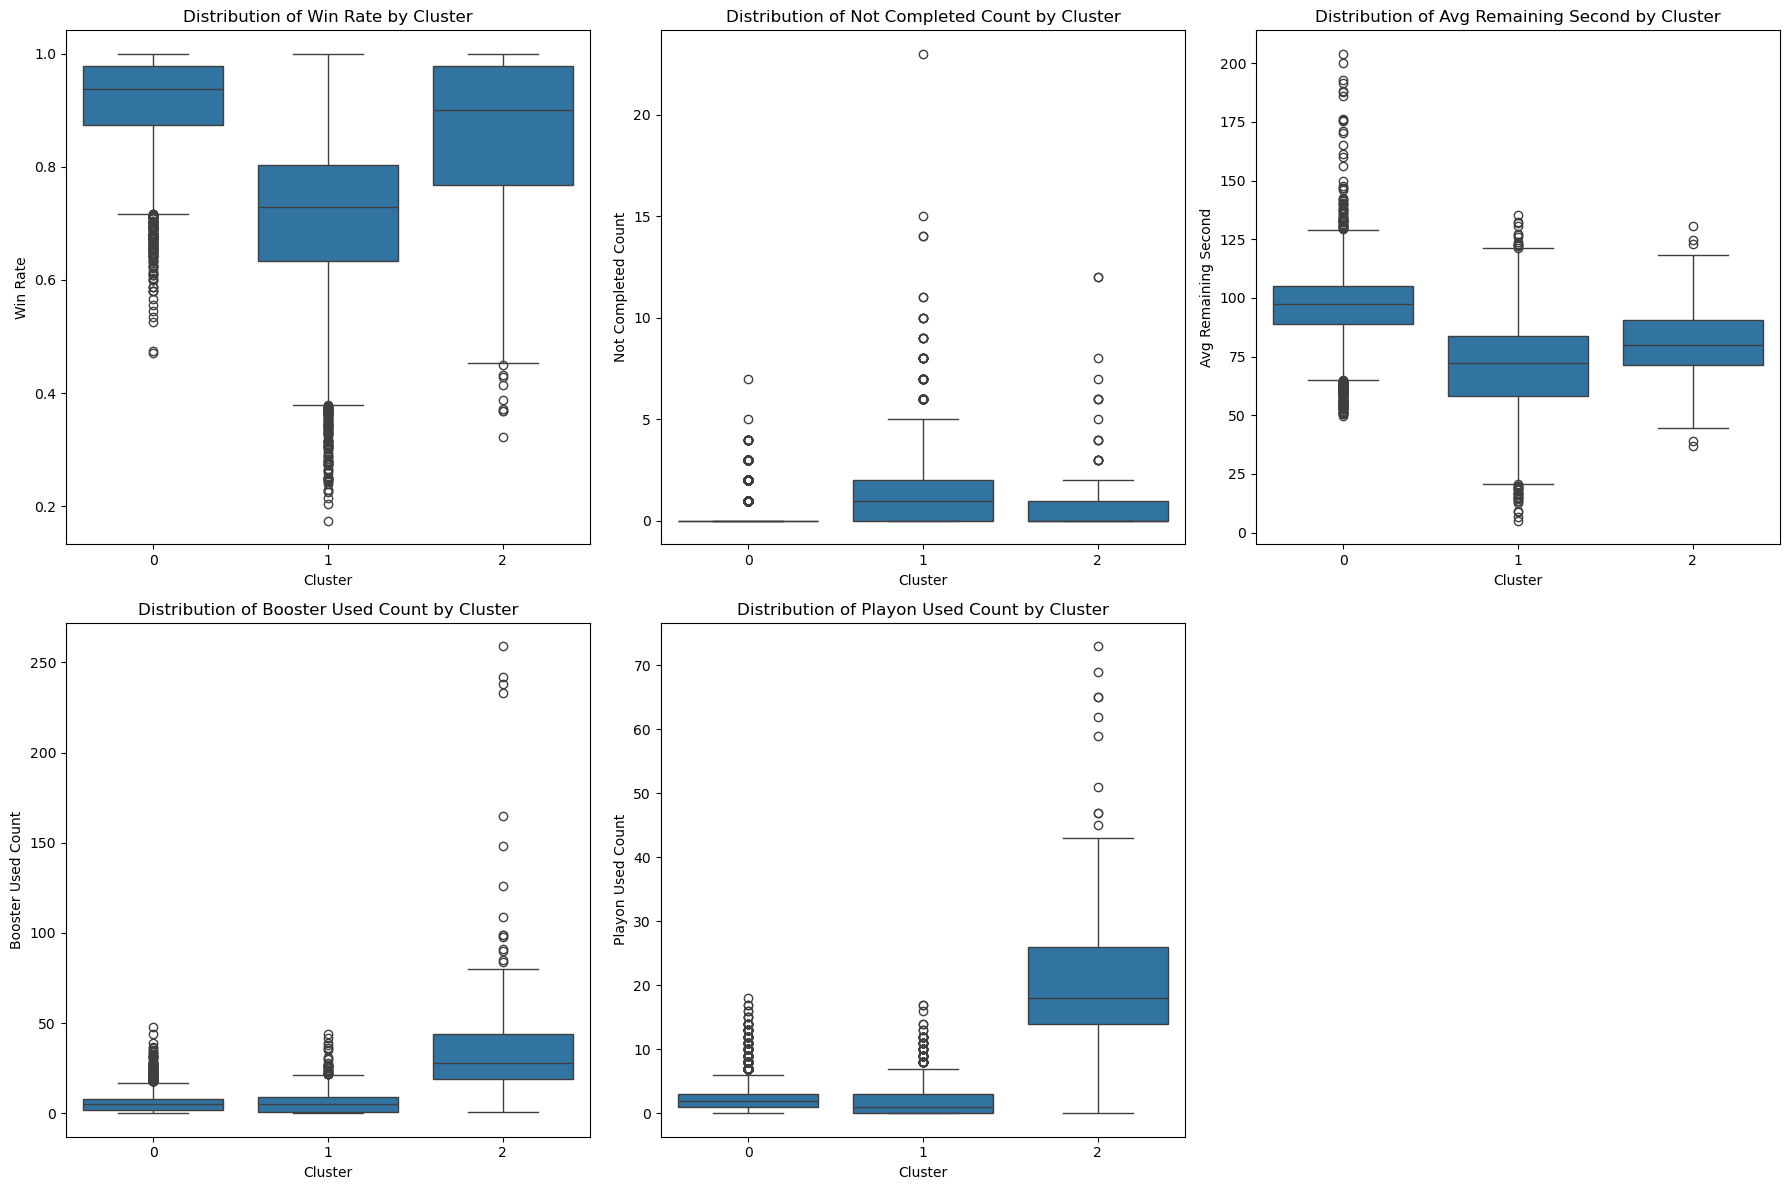

######################### POST-LEVEL 100 ######################## 


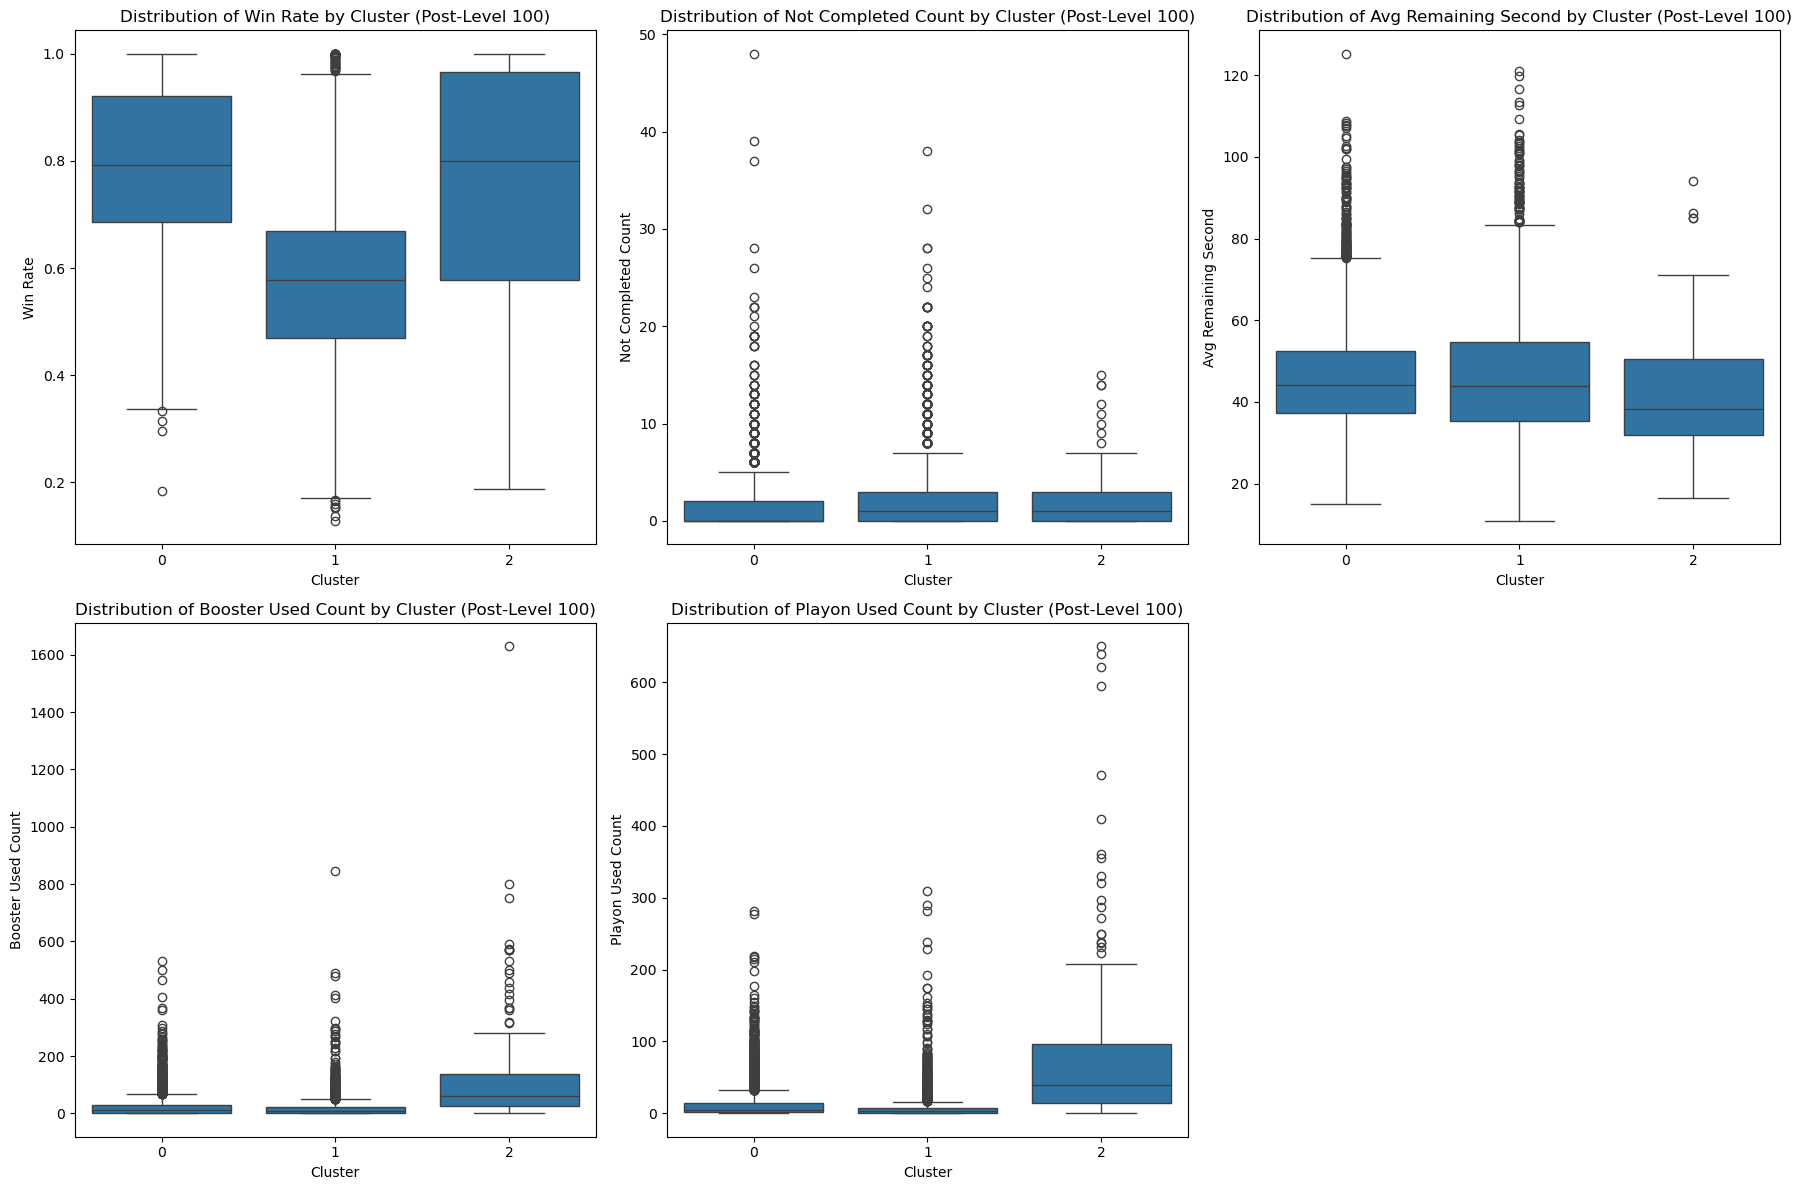

In [128]:
# Compare metric distributions by cluster for pre-level 100 and post-level 100 data
print("######################### PRE-LEVEL 100 #########################")
plt.figure(figsize=(18, 12))
metrics = ['win_rate', 'not_completed_count', 'avg_remaining_second', 'booster_used_count', 'playon_used_count']

# Plot metric distributions for clusters in pre-level 100 data
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x='Cluster', y=metric, data=user_level_stats)
    plt.title(f'Distribution of {metric.replace("_", " ").title()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric.replace("_", " ").title())

plt.tight_layout()
plt.show()


print("######################### POST-LEVEL 100 ######################## ")
plt.figure(figsize=(18, 12))

# Plot metric distributions for clusters in post-level 100 data
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x='Cluster', y=metric, data=level_100_plus_summary)
    plt.title(f'Distribution of {metric.replace("_", " ").title()} by Cluster (Post-Level 100)')
    plt.xlabel('Cluster')
    plt.ylabel(metric.replace("_", " ").title())

plt.tight_layout()
plt.show()


**VALIDATING THE RELATIONSHIP**

**Validating the Relationship with Logistic Regression**

In [130]:
# Prepare data for logistic regression model and evaluate performance
X = level_100_plus_summary[['win_rate', 'booster_used_count', 'playon_used_count',
                            'avg_remaining_second', 'not_completed_count']]
y = level_100_plus_summary['Cluster']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7995915241256063
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      2669
           1       0.73      0.59      0.65      1187
           2       0.48      0.20      0.28        61

    accuracy                           0.80      3917
   macro avg       0.68      0.56      0.60      3917
weighted avg       0.79      0.80      0.79      3917



**Validating the Relationship with ANOVA Test**

In [132]:
print("ANOVA Test Results:")

for metric in ['win_rate', 'not_completed_count', 'avg_remaining_second', 'booster_used_count', 'playon_used_count']:
    cluster_0 = level_100_plus_summary[level_100_plus_summary['Cluster'] == 0][metric]
    cluster_1 = level_100_plus_summary[level_100_plus_summary['Cluster'] == 1][metric]
    cluster_2 = level_100_plus_summary[level_100_plus_summary['Cluster'] == 2][metric]
    
    # ANOVA testi
    f_stat, p_val = f_oneway(cluster_0, cluster_1, cluster_2)
    print(f"{metric}: F-statistic = {f_stat:.2f}, p-value = {p_val:.10f}")


ANOVA Test Results:
win_rate: F-statistic = 3072.27, p-value = 0.0000000000
not_completed_count: F-statistic = 225.64, p-value = 0.0000000000
avg_remaining_second: F-statistic = 12.00, p-value = 0.0000062016
booster_used_count: F-statistic = 725.57, p-value = 0.0000000000
playon_used_count: F-statistic = 1040.09, p-value = 0.0000000000
